In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
#Adding rotation to the transforms
# Train Phase transformations
train_transforms2 = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms2 = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms2)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms2)

SEED=1

#CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

#For reproducibility
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

#dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

#test loader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

100%|██████████| 9912422/9912422 [00:00<00:00, 83999481.25it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42222270.42it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24185582.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8333564.64it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

CUDA Available? True


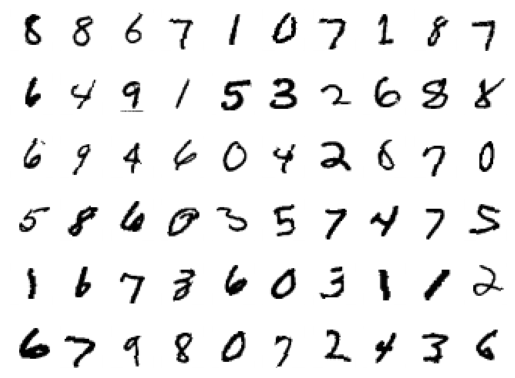

In [3]:
import matplotlib.pyplot as plt
figure=plt.figure()
num_images=60

dataiter = iter(train_loader)
images, labels = next(dataiter)

for index in range(1, num_images+1):
  plt.subplot(6,10,index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')


In [3]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar=tqdm(train_loader)
  correct=0
  processed=0

  for batch_idx, (data, target) in enumerate(pbar):
    #get samples
    data, target = data.to(device), target.to(device)

    #Init
    optimizer.zero_grad()

    #Predict
    y_pred=model(data)

    #Calculate loss
    loss=F.nll_loss(y_pred,target)
    train_losses.append(loss)

    #Backpropagation
    loss.backward()
    optimizer.step()

    #Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct+=pred.eq(target.view_as(pred)).sum().item()
    processed+= len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy = {100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item() #sum up batch loss
      pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /=len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100*correct/len(test_loader.dataset)))
  test_acc.append(100* correct/len(test_loader.dataset))

# Final Model
**Target -**

1. Image Augmentation
2. Correct max Polling locations
3. Add Learning Rate scheduler

In [4]:
#Fix Dropout value - make it 10% only, adding it in each layer
#Increasing capacity in initial & bottom layers
#Adding 1*1 conv (FC Layer) after GAP
#Perform MaxPolling at RF=5

dropout_value = 0.02
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26 ; RF=3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24 ; RF=5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24 ; RF_in + (k-1)J_in = 5 + (1-1) = 5 ; J_in = 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 ; RF=5+(2-1)1 = 6 ; J_out=2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 12 ; RF=6+(3-1)*2=10 ; J_Out=2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 12 ; RF=10+(3-1)*2=14 ; J_Out=2
        
        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 6 ; RF=14+(2-1)1 = 15 ; J_out=2
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12 ; RF_in + (k-1)J_in = 14 + (1-1) = 14 ; J_in = 1
       
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 6 ; RF=10+(3-1)*2=14 ; J_Out=2
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 6 ; RF=18+(3-1)*2=22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        
        x = self.pool1(x)
        x = self.convblock3(x)
        
        x = self.convblock4(x)
        x = self.convblock5(x)
        
        x = self.pool2(x)
        x = self.convblock6(x)
        
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)        
        x = self.convblock9(x)

        x = x.view(-1,10)
        return F.log_softmax(x, dim=-1)

In [5]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = Net5().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 10, 12, 12]             160
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [6]:
from torch.optim.lr_scheduler import StepLR

model = Net5().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
EPOCHS = 15

# Define your learning rate scheduler
scheduler = StepLR(optimizer, step_size=2, gamma=0.75)  # Reduce learning rate by a factor of 0.8 every 2 epochs


for epoch in range(EPOCHS):
    print('EPOCH: ',epoch+1, ' LR:',scheduler.get_last_lr()[0]) #
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

EPOCH:  1  LR: 0.05


Loss=0.08107111603021622 Batch_id=468 Accuracy = 91.34: 100%|██████████| 469/469 [00:09<00:00, 48.47it/s] 



Test set: Average loss: 0.0643, Accuracy: 9810/10000 (98.10%)

EPOCH:  2  LR: 0.05


Loss=0.10816218703985214 Batch_id=468 Accuracy = 97.74: 100%|██████████| 469/469 [00:09<00:00, 48.64it/s] 



Test set: Average loss: 0.0397, Accuracy: 9878/10000 (98.78%)

EPOCH:  3  LR: 0.037500000000000006


Loss=0.05095773935317993 Batch_id=468 Accuracy = 98.35: 100%|██████████| 469/469 [00:09<00:00, 50.20it/s]  



Test set: Average loss: 0.0362, Accuracy: 9888/10000 (98.88%)

EPOCH:  4  LR: 0.037500000000000006


Loss=0.023533890023827553 Batch_id=468 Accuracy = 98.52: 100%|██████████| 469/469 [00:09<00:00, 50.03it/s] 



Test set: Average loss: 0.0356, Accuracy: 9874/10000 (98.74%)

EPOCH:  5  LR: 0.028125000000000004


Loss=0.05661959946155548 Batch_id=468 Accuracy = 98.69: 100%|██████████| 469/469 [00:09<00:00, 49.15it/s]  



Test set: Average loss: 0.0309, Accuracy: 9902/10000 (99.02%)

EPOCH:  6  LR: 0.028125000000000004


Loss=0.06001640856266022 Batch_id=468 Accuracy = 98.80: 100%|██████████| 469/469 [00:09<00:00, 50.47it/s]  



Test set: Average loss: 0.0239, Accuracy: 9923/10000 (99.23%)

EPOCH:  7  LR: 0.02109375


Loss=0.040343865752220154 Batch_id=468 Accuracy = 98.97: 100%|██████████| 469/469 [00:09<00:00, 50.46it/s] 



Test set: Average loss: 0.0299, Accuracy: 9903/10000 (99.03%)

EPOCH:  8  LR: 0.02109375


Loss=0.03670867532491684 Batch_id=468 Accuracy = 99.00: 100%|██████████| 469/469 [00:09<00:00, 49.02it/s]  



Test set: Average loss: 0.0247, Accuracy: 9920/10000 (99.20%)

EPOCH:  9  LR: 0.015820312500000003


Loss=0.03034217096865177 Batch_id=468 Accuracy = 99.05: 100%|██████████| 469/469 [00:09<00:00, 49.70it/s]  



Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)

EPOCH:  10  LR: 0.015820312500000003


Loss=0.03444693610072136 Batch_id=468 Accuracy = 99.03: 100%|██████████| 469/469 [00:09<00:00, 50.11it/s]  



Test set: Average loss: 0.0213, Accuracy: 9936/10000 (99.36%)

EPOCH:  11  LR: 0.011865234375000002


Loss=0.012917681597173214 Batch_id=468 Accuracy = 99.16: 100%|██████████| 469/469 [00:09<00:00, 48.50it/s] 



Test set: Average loss: 0.0207, Accuracy: 9928/10000 (99.28%)

EPOCH:  12  LR: 0.011865234375000002


Loss=0.012478048913180828 Batch_id=468 Accuracy = 99.16: 100%|██████████| 469/469 [00:09<00:00, 51.48it/s] 



Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH:  13  LR: 0.00889892578125


Loss=0.01467195525765419 Batch_id=468 Accuracy = 99.22: 100%|██████████| 469/469 [00:09<00:00, 50.65it/s]  



Test set: Average loss: 0.0193, Accuracy: 9943/10000 (99.43%)

EPOCH:  14  LR: 0.00889892578125


Loss=0.00970915611833334 Batch_id=468 Accuracy = 99.25: 100%|██████████| 469/469 [00:09<00:00, 49.50it/s]  



Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

EPOCH:  15  LR: 0.0066741943359375005


Loss=0.08446411043405533 Batch_id=468 Accuracy = 99.25: 100%|██████████| 469/469 [00:09<00:00, 50.68it/s]  



Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)



# Results & Analysis

**Results:**

Parameters: 7.8k

Best Train Accuracy: 99.25%

Best Test Accuracy: 99.43%

**Analysis:**

No Over-fitting after image augmentation is added, model is getting tougher train dataset
Correct Maxpooling layer location is identified which is helping model achieve higher test accuracy
Learning rate scheduler is helping to gradually reduce LR from 0.05 to 0.0066 in the last EPOCH, this helps with better and smaller gradient descend steps 
Consistent 99.4% accuracy is achieved

